# Neural Network for inpainting one pixel an image using tensorflow 1

In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import matplotlib as plt
from data_generators import gen_frm_pic
from util_functions import util_functions

INDEX_TRGT = 12
INDEX_END = 24
ROW_SHAPE = (1,25)

Instructions for updating:
non-resource variables are not supported in the long term


## Generate images data

In [101]:
data,data_test = gen_frm_pic.generate_5()
print(data_test[0])
print(data_test[1])


[[[ 42  23   6]
  [ 35  16   1]
  [ 29  10   0]
  [ 32  14   0]
  [ 46  28  16]]

 [[103  83  59]
  [ 77  56  35]
  [ 45  24   3]
  [ 27   9   0]
  [ 36  17   0]]

 [[185 162 130]
  [164 143 112]
  [132 111  82]
  [113  92  65]
  [ 65  43  19]]

 [[186 163 122]
  [191 168 127]
  [182 158 120]
  [176 152 116]
  [186 162 128]]

 [[168 142  93]
  [167 140  93]
  [172 145  98]
  [186 159 114]
  [197 173 129]]]
[[[ 41  24  14]
  [ 39  22  12]
  [ 41  24  16]
  [ 39  24  17]
  [ 38  23  16]]

 [[ 32  13   0]
  [ 29  11   0]
  [ 32  14   2]
  [ 34  16   4]
  [ 31  13   3]]

 [[ 52  32   8]
  [ 41  20   0]
  [ 37  16   0]
  [ 37  16   0]
  [ 34  15   0]]

 [[158 135 103]
  [123 100  69]
  [ 94  70  42]
  [ 75  51  23]
  [ 62  38  12]]

 [[210 185 144]
  [196 171 131]
  [193 168 128]
  [188 162 125]
  [171 145 108]]]


## Split each pixel data to RGB channels

In [80]:
# red channel data
r_data = []

# green channel data
g_data = []

# blue channel data
b_data = []


for image in data:
    
    r_temp=[]
    b_temp=[]
    g_temp=[]
    for i in range(5):
        for j in range(5):
            r_temp.append(image[i][j][0])
            b_temp.append(image[i][j][1])
            g_temp.append(image[i][j][2])
    r_array=np.asarray(r_temp)
    g_array=np.asarray(r_temp)
    b_array=np.asarray(r_temp)
    util_functions.swap(r_array,INDEX_TRGT,INDEX_END)
    util_functions.swap(g_array,INDEX_TRGT,INDEX_END)
    util_functions.swap(b_array,INDEX_TRGT,INDEX_END)
    r_data.append(r_array)
    g_data.append(g_array)
    b_data.append(b_array)
    
r_test = []
g_test = []
b_test = []

for image in data_test:
    
    r_temp=[]
    b_temp=[]
    g_temp=[]
    for i in range(5):
        for j in range(5):
            r_temp.append(image[i][j][0])
            g_temp.append(image[i][j][1])
            b_temp.append(image[i][j][2])
    r_array=np.asarray(r_temp)
    g_array=np.asarray(g_temp)
    b_array=np.asarray(b_temp)
    util_functions.swap(r_array,INDEX_TRGT,INDEX_END)
    util_functions.swap(g_array,INDEX_TRGT,INDEX_END)
    util_functions.swap(b_array,INDEX_TRGT,INDEX_END)
    r_test.append(r_array)
    g_test.append(g_array)
    b_test.append(b_array)
    
data = [r_data, g_data, b_data]
test = [r_test, g_test, b_test]
print(r_test[0])
print(g_test[0])
print(b_test[0])

[ 42  35  29  32  46 103  77  45  27  36 185 164 197 113  65 186 191 182
 176 186 168 167 172 186 132]
[ 23  16  10  14  28  83  56  24   9  17 162 143 173  92  43 163 168 158
 152 162 142 140 145 159 111]
[  6   1   0   0  16  59  35   3   0   0 130 112 129  65  19 122 127 120
 116 128  93  93  98 114  82]


## Split data to train, test and vailation data

In [85]:


x_train_r = []
y_train_r = []

x_test_r = []
x_test_g = []
x_test_b = []

y_test_r = []
y_test_g = []
y_test_b = []

for i in range(len(r_data)):
    x_train_r.append(r_data[i][0:INDEX_END].tolist())
    y_train_r.append([r_data[i][INDEX_END]])

for i in range(len(r_test)):
    
    x_test_r.append(r_test[i][0:INDEX_END].tolist())
    x_test_g.append(g_test[i][0:INDEX_END].tolist())
    x_test_b.append(b_test[i][0:INDEX_END].tolist())

    y_test_r.append([r_test[i][INDEX_END]])
    y_test_g.append([g_test[i][INDEX_END]])
    y_test_b.append([b_test[i][INDEX_END]])


x_testers = [x_test_r,x_test_g,x_test_b]
y_testers = [y_test_r,y_test_g,y_test_b]
print(x_test_r[0])

[42, 35, 29, 32, 46, 103, 77, 45, 27, 36, 185, 164, 197, 113, 65, 186, 191, 182, 176, 186, 168, 167, 172, 186]


In [5]:
x_train_r[1]

[104,
 93,
 80,
 82,
 75,
 97,
 95,
 92,
 88,
 81,
 91,
 93,
 87,
 95,
 89,
 87,
 87,
 88,
 96,
 91,
 82,
 84,
 87,
 94]

## Model

In [6]:
features = 24 # each pixel
hidden_layer_nodes = 16
loss_plot = []
test_plot = []
x = tf.placeholder(tf.float32, [None, features])
y_ = tf.placeholder(tf.float32, [None, 1])
W1 = tf.Variable(tf.truncated_normal([features, hidden_layer_nodes]))
b1 = tf.Variable(tf.constant(0.1, shape=[hidden_layer_nodes]))
z1 = tf.add(tf.matmul(x,W1),b1)
a1 = tf.nn.relu(z1) # using relu function
W2 = tf.Variable(tf.truncated_normal([hidden_layer_nodes,1]))
b2 = tf.Variable(0.)
z2 = tf.matmul(a1,W2) + b2
st_w = []
nd_w = []

loss = tf.reduce_mean(tf.pow(z2 - y_, 2))
update = tf.train.AdamOptimizer(0.001).minimize(loss) # using adam optimizer

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(0,10000):
        sess.run(update, feed_dict = {x:x_train_r, y_:y_train_r})
        st_w.append(sess.run(W1))
        nd_w.append(sess.run(W2))
#         loss_plot.append(loss.eval(session=sess, feed_dict = {x:x_train_r, y_:y_train_r}))
#         test_plot.append(loss.eval(session=sess,feed_dict = {x:x_testers[0],y_:y_testers[0]}))

In [7]:
print(np.sqrt(loss.eval(session=sess, feed_dict = {x:x_train_r, y_:y_train_r})))

3.912907


[ 0.6458078  -1.6105723   1.6243376  -0.45313388 -1.0455402  -1.0087045
 -1.418447   -0.13969998  0.83939123 -1.203666    0.35891354  0.18061507
  0.38902748  0.08202568  1.1483005  -0.2130314  -1.4496152   1.5345676
  0.68369097 -0.5662077  -0.7569122  -0.4635392  -0.08979792  0.63165027]


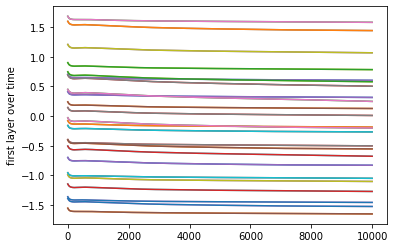

In [9]:
d = np.array(np.array(st_w).transpose()[0]).transpose()
print(d[900])
plt.pyplot.plot(d)
plt.pyplot.ylabel('first layer over time')
plt.pyplot.plot(d)

[ 0.350817    1.8574142  -0.24823491 -1.9555566   0.64207417  0.5498483
 -0.00724694  0.70345604 -0.37735432 -1.3782353   0.6473259  -0.03658207
  2.140557    1.0461307  -0.18031983 -0.05804102]


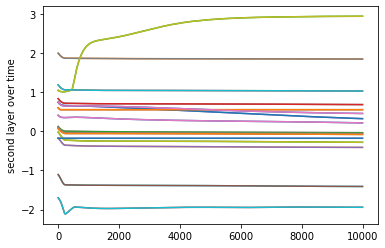

In [10]:
d = np.array(np.array(nd_w).transpose()[0]).transpose()
print(d[900])
plt.pyplot.plot(d)
plt.pyplot.ylabel('second layer over time')
plt.pyplot.plot(d)

In [86]:

print("sqaured test error on the red channel:", np.sqrt(loss.eval(session=sess, feed_dict = {x:x_testers[0], y_:y_testers[0]})))
print("sqaured test error on the green channel:", np.sqrt(loss.eval(session=sess, feed_dict = {x:x_testers[1], y_:y_testers[1]})))
print("sqaured test error on the blue channel:", np.sqrt(loss.eval(session=sess, feed_dict = {x:x_testers[2], y_:y_testers[2]})))

sqaured test error on the red channel: 6.5161524
sqaured test error on the red channel: 13.916964
sqaured test error on the red channel: 28.060259


In [87]:
# x_testers[0][0] 
# x_testers[1][0] 
# x_testers[2][0]

arr_r = np.asarray(x_testers[0])
arr_g =  np.asarray(x_testers[1])
arr_b =  np.asarray(x_testers[2])
p_r = sess.run(tf.nn.relu(z2),feed_dict={x:arr_r})
p_g = sess.run(tf.nn.relu(z2),feed_dict={x:arr_g})
p_b = sess.run(tf.nn.relu(z2),feed_dict={x:arr_b})


In [100]:
matrices = []
for i in range(len(arr_r)):
    temp_r = arr_r[i].tolist()
    temp_g = arr_g[i].tolist()
    temp_b = arr_b[i].tolist()
    temp_r.append(int(p_r[i][0]))
    temp_g.append(int(p_g[i][0]))
    temp_b.append(int(p_b[i][0]))
    util_functions.swap(temp_r,INDEX_TRGT,INDEX_END)
    util_functions.swap(temp_g,INDEX_TRGT,INDEX_END)
    util_functions.swap(temp_b,INDEX_TRGT,INDEX_END)
    k = 0
    mat = []
    for j in range(0,5):
        matrice = []
        for m in range(0,5):
            pixel = [temp_r[k],temp_g[k],temp_b[k]]
            k+=1
            matrice.append(pixel)
        mat.append(matrice)
    matrix = np.asarray(mat)
    matrices.append(matrix)
print(len(matrices))
print(matrices[0])
print(matrices[1])

6400
[[[ 42  23   6]
  [ 35  16   1]
  [ 29  10   0]
  [ 32  14   0]
  [ 46  28  16]]

 [[103  83  59]
  [ 77  56  35]
  [ 45  24   3]
  [ 27   9   0]
  [ 36  17   0]]

 [[185 162 130]
  [164 143 112]
  [134 112  79]
  [113  92  65]
  [ 65  43  19]]

 [[186 163 122]
  [191 168 127]
  [182 158 120]
  [176 152 116]
  [186 162 128]]

 [[168 142  93]
  [167 140  93]
  [172 145  98]
  [186 159 114]
  [197 173 129]]]
[[[ 41  24  14]
  [ 39  22  12]
  [ 41  24  16]
  [ 39  24  17]
  [ 38  23  16]]

 [[ 32  13   0]
  [ 29  11   0]
  [ 32  14   2]
  [ 34  16   4]
  [ 31  13   3]]

 [[ 52  32   8]
  [ 41  20   0]
  [ 38  19  12]
  [ 37  16   0]
  [ 34  15   0]]

 [[158 135 103]
  [123 100  69]
  [ 94  70  42]
  [ 75  51  23]
  [ 62  38  12]]

 [[210 185 144]
  [196 171 131]
  [193 168 128]
  [188 162 125]
  [171 145 108]]]


In [104]:
from PIL import Image as mg


data = matrices
i = 0
lines = []
# i += 1
size = 5
data_size = (len(data))

for _ in range(80):
    concat = data[i]
    i+=1
    for _ in range(1,80):
        temp = data[i]
        concat = np.concatenate((concat, temp), axis=1)
        i += 1
    print(concat.shape)
    lines.append(concat)

concat = lines[0]

for i in range(1, len(lines)):
    concat = np.concatenate((concat, lines[i]), axis=0)



im = mg.fromarray(concat,'RGB')
im.save("output_image_neural_network.jpeg")

(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
(5, 400, 3)
